In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

/kaggle/input/avcrosssell/train.csv
/kaggle/input/avcrosssell/test.csv
/kaggle/input/avcrosssell/sample_submission.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/avcrosssell/train.csv')

print(train_data.shape)

train_data.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
test_data = pd.read_csv('/kaggle/input/avcrosssell/test.csv')

print(test_data.shape)

test_data.head()

(127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [4]:
x = train_data[~train_data.iloc[:,1:].duplicated(keep = 'first')]

#confusing ids

train_data = train_data[~train_data.id.isin(x[x.iloc[:,1:-1].duplicated(keep = False)].id)]

In [5]:
def nullColumns(train_data):
    
    list_of_nullcolumns =[]
    
    for column in train_data.columns:
        
        total= train_data[column].isna().sum()
        
        try:
            
            if total !=0:
                
                print('Total Na values is {0} for column {1}' .format(total, column))
                
                list_of_nullcolumns.append(column)
        
        except:
            
            print(column,"-----",total)
    
    print('\n')
    
    return list_of_nullcolumns


def percentMissingFeature(data):
    
    data_na = (data.isnull().sum() / len(data)) * 100
    
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    
    return data_na


def plotMissingFeature(data_na):
    
    f, ax = plt.subplots(figsize=(15, 12))
    
    plt.xticks(rotation='90')
    
    if(data_na.empty ==False):
        
        sns.barplot(x=data_na.index, y=data_na)
        
        plt.xlabel('Features', fontsize=15)
        
        plt.ylabel('Percent of missing values', fontsize=15)
        
        plt.title('Percent missing data by feature', fontsize=15)

In [6]:
print('train data')

print(nullColumns(train_data))

print(percentMissingFeature(train_data))

print('\n')

print('test_data')

print(nullColumns(test_data))

print(percentMissingFeature(test_data))

train data


[]
Series([], dtype: float64)


test_data


[]
Series([], dtype: float64)


Text(0.5, 1.0, 'Response')

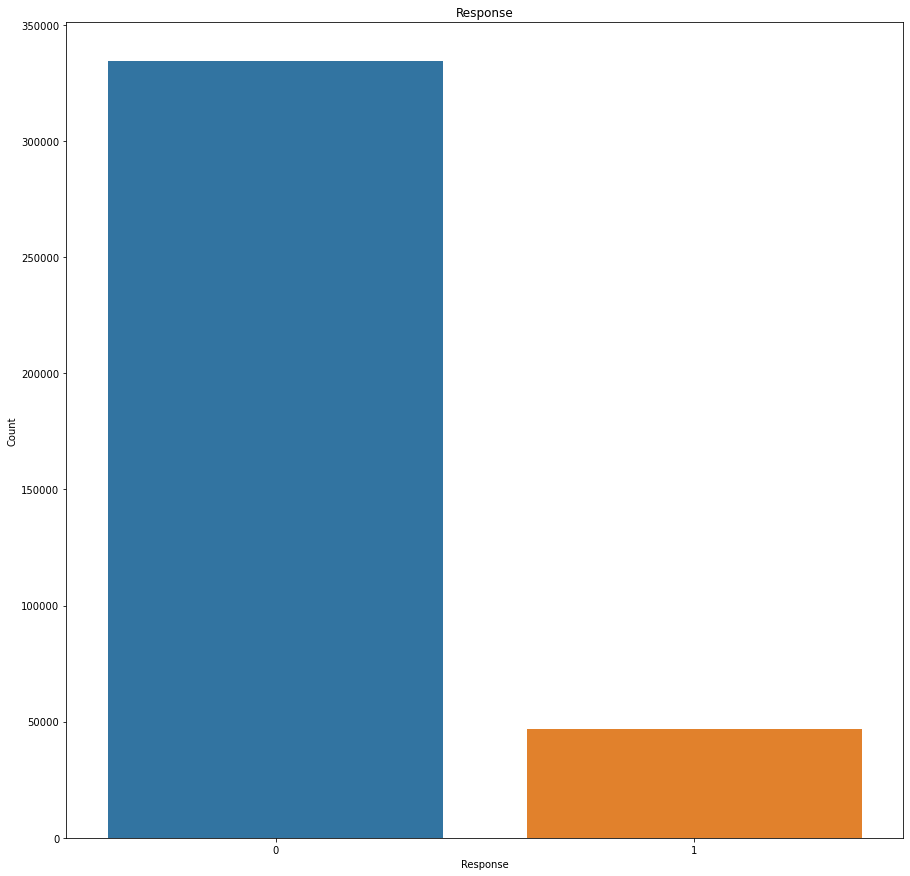

In [7]:
response = train_data.loc[:,"Response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(response.index , response.values).set_title('Response')

In [8]:
response

0    334346
1     46657
Name: Count, dtype: int64

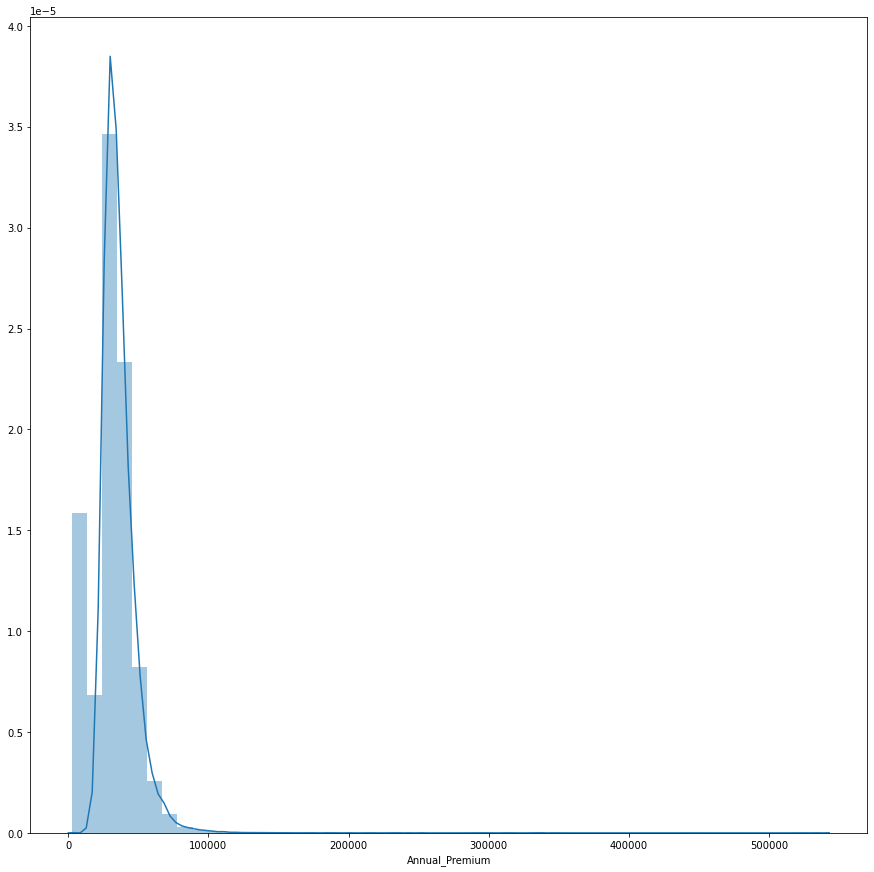

In [9]:
sns.distplot(train_data['Annual_Premium'])

# FE

In [10]:
train_data['Policy_Region'] = train_data['Policy_Sales_Channel'].astype(str)+'_'+train_data['Region_Code'].astype(str)

test_data['Policy_Region'] = test_data['Policy_Sales_Channel'].astype(str)+'_'+test_data['Region_Code'].astype(str)

train_data['Vehicle_Age_License'] = train_data['Vehicle_Age'].astype(str)+'_'+train_data['Driving_License'].astype(str)

test_data['Vehicle_Age_License'] = test_data['Vehicle_Age'].astype(str)+'_'+test_data['Driving_License'].astype(str)

In [11]:
cat_features = ['Gender','Driving_License','Region_Code','Previously_Insured',
                'Vehicle_Damage','Policy_Sales_Channel','Policy_Region',
                'Vehicle_Age','Vintage','Annual_Premium','Vehicle_Age_License']

cont_features = ['Age']

label = 'Response'

In [12]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        if col!= 'Vehicle_Age':
        
            le = LabelEncoder()

            le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())

            train_df[col] = le.transform(train_df[[col]])

            test_df[col] = le.transform(test_df[[col]])

            le_dict[col] = le
        
    train_df['Vehicle_Age'] = train_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    
    test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    
    return train_df, test_df, le_dict

In [13]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_features)

In [14]:
train_df = train_df[~train_df.Policy_Sales_Channel.isin(list(set(train_df.Policy_Sales_Channel)-set(test_df.Policy_Sales_Channel)))]

#test_df.loc[(test_df.Policy_Sales_Channel.isin(list(set(test_df.Policy_Sales_Channel) - set(train_df.Policy_Sales_Channel)))),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==137),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==136),'Policy_Sales_Channel'] = -1

In [15]:
test_df.loc[(test_df.Annual_Premium.isin(list(set(test_df.Annual_Premium) - set(train_df.Annual_Premium)))),'Annual_Premium'] = -1

In [16]:
train_df['train'] = 1

test_df['train'] = 0

combined_data = pd.concat([train_df,test_df],axis =0).reset_index(drop = True).copy()

In [17]:
premium_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

combined_data['Premium_Bins'] =premium_discretizer.fit_transform(combined_data['Annual_Premium'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

combined_data['Age_Bins'] =age_discretizer.fit_transform(combined_data['Age'].values.reshape(-1,1)).astype(int)

In [18]:
gender_counts = combined_data['Gender'].value_counts().to_dict()

combined_data['Gender_Counts'] = combined_data['Gender'].map(gender_counts)

region_counts = combined_data['Region_Code'].value_counts().to_dict()

combined_data['Region_counts'] = combined_data['Region_Code'].map(region_counts)

vehicle_age_counts = combined_data['Vehicle_Age'].value_counts().to_dict()

combined_data['Vehicle_Age_Counts'] = combined_data['Vehicle_Age'].map(vehicle_age_counts)

In [19]:
combined_data['Nunq_Policy_Per_Region'] = combined_data.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique') 

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] = combined_data.groupby('Region_Code')['Annual_Premium'].transform('std').fillna(-1) 

combined_data['Nunq_Region_Per_Premium'] = combined_data.groupby('Annual_Premium')['Region_Code'].transform('nunique')

# 1230.45 can be split into “1230” and “45”. LGBM cannot see these pieces on its own, you need to split them.
combined_data['SDev_Annual_Premium_Per_Region_Code_dec'] = combined_data['SDev_Annual_Premium_Per_Region_Code_int'] %1

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] =combined_data['SDev_Annual_Premium_Per_Region_Code_int'].astype(int)


combined_data['Avg_Policy_Region_Age'] = combined_data.groupby(['Policy_Region'])['Age'].transform('mean')

combined_data['Avg_Policy_Region_Premium'] = combined_data.groupby(['Policy_Region'])['Annual_Premium'].transform('mean') 

combined_data['Avg_Region_Premium'] = combined_data.groupby(['Region_Code'])['Annual_Premium'].transform('mean')

combined_data['Nunq_Premium_Region'] = combined_data.groupby(['Annual_Premium'])['Region_Code'].transform('nunique')

In [20]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [21]:
cols = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
        'Annual_Premium','Policy_Sales_Channel', 'Vintage']

train_df = train_df[~train_df.loc[:,cols].duplicated(keep = 'first')].reset_index(drop=True)

In [22]:
target = train_df['Response']

train_df = train_df.drop(columns =['train','id','Response'])

test_df = test_df.drop(columns=['train','id','Response'])

In [23]:
train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Region_counts,Vehicle_Age_Counts,Nunq_Policy_Per_Region,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium,Nunq_Premium_Region
0,1,44,1,28,0,3,1,24158,24,207,...,141873,21323,121,12416,6,0.626550,51.397261,23278.327950,22142.483609,6
1,1,76,1,3,0,2,0,17240,24,173,...,12345,266897,64,9385,10,0.058878,50.517411,11951.893304,10813.151073,10
2,1,47,1,28,0,3,1,21998,24,17,...,141873,21323,121,12416,11,0.626550,51.397261,23278.327950,22142.483609,11
3,1,21,1,11,1,1,0,12323,147,193,...,12328,219792,53,9691,12,0.643929,25.735264,14089.018263,13235.062297,12
4,0,29,1,41,1,1,0,11200,147,29,...,24399,219792,67,10464,11,0.521681,26.792402,16258.510302,15730.565720,11


# XgBoost

In [24]:
trees = 5

n_splits = 5

seeds = [32,432,73,5,2]

submission = pd.read_csv('../input/avcrosssell/sample_submission.csv')

probs = np.zeros(shape=(len(test_df),))

# probablity file per seed per split per tree
submission_probs = pd.DataFrame(columns = ['id','Response'])

submission_probs.iloc[:,0] = submission.iloc[:,0]

submission_probs.iloc[:,1:] = 0

In [25]:
%%time

##XGBM

scores = []

avg_loss = []

submission_name = []

seed_no = []

fold_no = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage',
                'Annual_Premium','Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

for seed in tnrange(len(seeds)):
    
    sssf = StratifiedShuffleSplit(n_splits=n_splits, test_size = 0.3 ,random_state=seeds[seed])

    for j, (idxT, idxV) in tqdm(enumerate(sssf.split(X_train_cv, y_train_cv))):
        
        print('Fold',j)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        model_xgb = [0] *trees

        for i in tnrange(trees):

            print('Tree',i)
            
            seed_no.append(seeds[seed])
            
            fold_no.append(j)
            
            model_xgb[i] = xgb.XGBClassifier(n_estimators=1000,
                                max_depth=6,
                                learning_rate=0.04,
                                subsample=0.9,
                                colsample_bytree=0.35,
                                objective = 'binary:logistic',
                                random_state = i*27
                               )        
  
            
            model_xgb[i].fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['auc','logloss'],
                    early_stopping_rounds=50)


            probs_file_name = 'probs_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            model_xgb_probs = model_xgb[i].predict_proba(test_df)[:,1]
            
            submission_probs.iloc[:,1:] = model_xgb_probs
            
            # probablity file per seed per split per tree
            submission_probs.to_csv(probs_file_name,index = False)
            
            probs += model_xgb_probs
            
            probs_oof = model_xgb[i].predict_proba(X_train_cv.iloc[idxV])[:,1]
            
            roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

            scores.append(roc)

            avg_loss.append(model_xgb[i].best_score)
            
            submission_name.append(probs_file_name)
            
            print ('XGB ROC OOF =',roc)
            
            print('#'*100)
    

print("Average Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))


Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
[0]	validation_0-auc:0.82066	validation_0-logloss:0.66814
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85608	validation_0-logloss:0.27577
[200]	validation_0-auc:0.85846	validation_0-logloss:0.26528
[300]	validation_0-auc:0.85892	validation_0-logloss:0.26409
[400]	validation_0-auc:0.85898	validation_0-logloss:0.26394
Stopping. Best iteration:
[396]	validation_0-auc:0.85898	validation_0-logloss:0.26393

XGB ROC OOF = 0.8589822069705472
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72938	validation_0-logloss:0.66946
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85531	validation_0-logloss:0.27742
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.82434	validation_0-logloss:0.66818
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85724	validation_0-logloss:0.27535
[200]	validation_0-auc:0.85945	validation_0-logloss:0.26493
[300]	validation_0-auc:0.85960	validation_0-logloss:0.26395
Stopping. Best iteration:
[341]	validation_0-auc:0.85966	validation_0-logloss:0.26388

XGB ROC OOF = 0.8596556145430175
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73202	validation_0-logloss:0.66951
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85677	validation_0-logloss:0.27684
[200]	validation_0-auc:0.85933	validation_0-logloss:0.26518
[300]	validation_0-

Tree 0
[0]	validation_0-auc:0.82269	validation_0-logloss:0.66813
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85722	validation_0-logloss:0.27532
[200]	validation_0-auc:0.85950	validation_0-logloss:0.26465
[300]	validation_0-auc:0.85960	validation_0-logloss:0.26349
[400]	validation_0-auc:0.85947	validation_0-logloss:0.26337
Stopping. Best iteration:
[419]	validation_0-auc:0.85945	validation_0-logloss:0.26336

XGB ROC OOF = 0.8594553094199311
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72971	validation_0-logloss:0.66951
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85667	validation_0-logloss:0.27695
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.81996	validation_0-logloss:0.66817
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85655	validation_0-logloss:0.27548
[200]	validation_0-auc:0.85842	validation_0-logloss:0.26523
[300]	validation_0-auc:0.85848	validation_0-logloss:0.26433
Stopping. Best iteration:
[347]	validation_0-auc:0.85846	validation_0-logloss:0.26428

XGB ROC OOF = 0.8584617418880341
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72910	validation_0-logloss:0.66952
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85597	validation_0-logloss:0.27702
[200]	validation_0-auc:0.85836	validation_0-logloss:0.26547
[300]	validation_0-

Tree 0
[0]	validation_0-auc:0.82349	validation_0-logloss:0.66814
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85711	validation_0-logloss:0.27514
[200]	validation_0-auc:0.85892	validation_0-logloss:0.26467
[300]	validation_0-auc:0.85890	validation_0-logloss:0.26361
[400]	validation_0-auc:0.85863	validation_0-logloss:0.26361
Stopping. Best iteration:
[353]	validation_0-auc:0.85878	validation_0-logloss:0.26357

XGB ROC OOF = 0.858783287691629
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73322	validation_0-logloss:0.66948
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85662	validation_0-logloss:0.27675
[200]	validation_0-a

Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
[0]	validation_0-auc:0.82216	validation_0-logloss:0.66816
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85786	validation_0-logloss:0.27477
[200]	validation_0-auc:0.85996	validation_0-logloss:0.26419
[300]	validation_0-auc:0.86020	validation_0-logloss:0.26303
Stopping. Best iteration:
[343]	validation_0-auc:0.86016	validation_0-logloss:0.26297

XGB ROC OOF = 0.8601603096746467
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73425	validation_0-logloss:0.66953
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85733	validation_0-logloss:0.27637
[200]	validation_0-auc:0.85987	validation_0-logloss:0.26445
[300]	validation_0-

Tree 0
[0]	validation_0-auc:0.82276	validation_0-logloss:0.66815
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85723	validation_0-logloss:0.27504
[200]	validation_0-auc:0.85942	validation_0-logloss:0.26457
[300]	validation_0-auc:0.85952	validation_0-logloss:0.26357
Stopping. Best iteration:
[323]	validation_0-auc:0.85947	validation_0-logloss:0.26355

XGB ROC OOF = 0.8594702227579242
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73049	validation_0-logloss:0.66950
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85699	validation_0-logloss:0.27649
[200]	validation_0-auc:0.85956	validation_0-logloss:0.26475
[300]	validation_0-

Tree 0
[0]	validation_0-auc:0.82135	validation_0-logloss:0.66819
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85498	validation_0-logloss:0.27609
[200]	validation_0-auc:0.85738	validation_0-logloss:0.26583
[300]	validation_0-auc:0.85761	validation_0-logloss:0.26485
[400]	validation_0-auc:0.85760	validation_0-logloss:0.26483
Stopping. Best iteration:
[358]	validation_0-auc:0.85764	validation_0-logloss:0.26480

XGB ROC OOF = 0.8576437001147452
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72785	validation_0-logloss:0.66948
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85426	validation_0-logloss:0.27773
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.82014	validation_0-logloss:0.66824
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85507	validation_0-logloss:0.27632
[200]	validation_0-auc:0.85717	validation_0-logloss:0.26624
[300]	validation_0-auc:0.85732	validation_0-logloss:0.26544
Stopping. Best iteration:
[324]	validation_0-auc:0.85730	validation_0-logloss:0.26543

XGB ROC OOF = 0.8573049981594734
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72648	validation_0-logloss:0.66951
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85439	validation_0-logloss:0.27790
[200]	validation_0-auc:0.85685	validation_0-logloss:0.26656
[300]	validation_0-

Tree 0
[0]	validation_0-auc:0.82259	validation_0-logloss:0.66816
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85647	validation_0-logloss:0.27561
[200]	validation_0-auc:0.85855	validation_0-logloss:0.26521
[300]	validation_0-auc:0.85862	validation_0-logloss:0.26420
[400]	validation_0-auc:0.85849	validation_0-logloss:0.26414
Stopping. Best iteration:
[397]	validation_0-auc:0.85852	validation_0-logloss:0.26413

XGB ROC OOF = 0.8585170554722024
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73201	validation_0-logloss:0.66953
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85564	validation_0-logloss:0.27729
[200]	validation_0-

Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
[0]	validation_0-auc:0.82317	validation_0-logloss:0.66816
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85732	validation_0-logloss:0.27517
[200]	validation_0-auc:0.85927	validation_0-logloss:0.26468
[300]	validation_0-auc:0.85916	validation_0-logloss:0.26367
[400]	validation_0-auc:0.85904	validation_0-logloss:0.26361
Stopping. Best iteration:
[370]	validation_0-auc:0.85915	validation_0-logloss:0.26359

XGB ROC OOF = 0.8591520538350375
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73135	validation_0-logloss:0.66948
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85665	validation_0-logloss:0.27684
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.82208	validation_0-logloss:0.66819
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85686	validation_0-logloss:0.27528
[200]	validation_0-auc:0.85913	validation_0-logloss:0.26476
[300]	validation_0-auc:0.85932	validation_0-logloss:0.26366
[400]	validation_0-auc:0.85931	validation_0-logloss:0.26356
Stopping. Best iteration:
[397]	validation_0-auc:0.85932	validation_0-logloss:0.26355

XGB ROC OOF = 0.859315908332167
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72879	validation_0-logloss:0.66946
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85617	validation_0-logloss:0.27690
[200]	validation_0-a

Tree 0
[0]	validation_0-auc:0.82216	validation_0-logloss:0.66813
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85609	validation_0-logloss:0.27565
[200]	validation_0-auc:0.85835	validation_0-logloss:0.26534
[300]	validation_0-auc:0.85857	validation_0-logloss:0.26437
Stopping. Best iteration:
[341]	validation_0-auc:0.85854	validation_0-logloss:0.26434

XGB ROC OOF = 0.8585416012474041
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72834	validation_0-logloss:0.66952
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85554	validation_0-logloss:0.27720
[200]	validation_0-auc:0.85836	validation_0-logloss:0.26552
[300]	validation_0-

Tree 0
[0]	validation_0-auc:0.82058	validation_0-logloss:0.66814
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85739	validation_0-logloss:0.27525
[200]	validation_0-auc:0.85971	validation_0-logloss:0.26465
[300]	validation_0-auc:0.85975	validation_0-logloss:0.26363
[400]	validation_0-auc:0.85963	validation_0-logloss:0.26356
Stopping. Best iteration:
[368]	validation_0-auc:0.85969	validation_0-logloss:0.26356

XGB ROC OOF = 0.8596899514534865
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72959	validation_0-logloss:0.66953
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85677	validation_0-logloss:0.27684
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.82127	validation_0-logloss:0.66819
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85626	validation_0-logloss:0.27575
[200]	validation_0-auc:0.85884	validation_0-logloss:0.26528
[300]	validation_0-auc:0.85912	validation_0-logloss:0.26426
Stopping. Best iteration:
[343]	validation_0-auc:0.85913	validation_0-logloss:0.26421

XGB ROC OOF = 0.859131618874486
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72927	validation_0-logloss:0.66954
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85579	validation_0-logloss:0.27729
[200]	validation_0-auc:0.85878	validation_0-logloss:0.26552
[300]	validation_0-a

Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
[0]	validation_0-auc:0.82234	validation_0-logloss:0.66819
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85611	validation_0-logloss:0.27543
[200]	validation_0-auc:0.85809	validation_0-logloss:0.26500
[300]	validation_0-auc:0.85829	validation_0-logloss:0.26386
[400]	validation_0-auc:0.85817	validation_0-logloss:0.26378
Stopping. Best iteration:
[396]	validation_0-auc:0.85819	validation_0-logloss:0.26377

XGB ROC OOF = 0.8581875323273295
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73159	validation_0-logloss:0.66952
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85547	validation_0-logloss:0.27708
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.81954	validation_0-logloss:0.66822
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85571	validation_0-logloss:0.27587
[200]	validation_0-auc:0.85810	validation_0-logloss:0.26542
[300]	validation_0-auc:0.85830	validation_0-logloss:0.26440
Stopping. Best iteration:
[341]	validation_0-auc:0.85825	validation_0-logloss:0.26438

XGB ROC OOF = 0.8582486471279386
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72819	validation_0-logloss:0.66958
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85536	validation_0-logloss:0.27737
[200]	validation_0-auc:0.85802	validation_0-logloss:0.26569
[300]	validation_0-

Tree 0
[0]	validation_0-auc:0.82287	validation_0-logloss:0.66817
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85698	validation_0-logloss:0.27519
[200]	validation_0-auc:0.85904	validation_0-logloss:0.26466
[300]	validation_0-auc:0.85903	validation_0-logloss:0.26366
[400]	validation_0-auc:0.85884	validation_0-logloss:0.26364
Stopping. Best iteration:
[364]	validation_0-auc:0.85892	validation_0-logloss:0.26361

XGB ROC OOF = 0.8589234473204499
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72988	validation_0-logloss:0.66953
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85638	validation_0-logloss:0.27677
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.82222	validation_0-logloss:0.66818
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85734	validation_0-logloss:0.27511
[200]	validation_0-auc:0.85932	validation_0-logloss:0.26469
[300]	validation_0-auc:0.85947	validation_0-logloss:0.26357
[400]	validation_0-auc:0.85931	validation_0-logloss:0.26351
Stopping. Best iteration:
[383]	validation_0-auc:0.85938	validation_0-logloss:0.26351

XGB ROC OOF = 0.8593750845200896
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73049	validation_0-logloss:0.66949
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85676	validation_0-logloss:0.27670
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.82366	validation_0-logloss:0.66814
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85660	validation_0-logloss:0.27557
[200]	validation_0-auc:0.85893	validation_0-logloss:0.26506
[300]	validation_0-auc:0.85899	validation_0-logloss:0.26402
Stopping. Best iteration:
[323]	validation_0-auc:0.85897	validation_0-logloss:0.26399

XGB ROC OOF = 0.8589716794049641
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72883	validation_0-logloss:0.66946
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85600	validation_0-logloss:0.27719
[200]	validation_0-auc:0.85865	validation_0-logloss:0.26539
[300]	validation_0-

Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
[0]	validation_0-auc:0.82234	validation_0-logloss:0.66817
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85603	validation_0-logloss:0.27557
[200]	validation_0-auc:0.85813	validation_0-logloss:0.26517
[300]	validation_0-auc:0.85820	validation_0-logloss:0.26417
Stopping. Best iteration:
[345]	validation_0-auc:0.85811	validation_0-logloss:0.26415

XGB ROC OOF = 0.8581072339627689
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73111	validation_0-logloss:0.66951
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85562	validation_0-logloss:0.27708
[200]	validation_0-auc:0.85816	validation_0-logloss:0.26541
[300]	validation_0-

Tree 0
[0]	validation_0-auc:0.82247	validation_0-logloss:0.66819
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85673	validation_0-logloss:0.27538
[200]	validation_0-auc:0.85889	validation_0-logloss:0.26492
[300]	validation_0-auc:0.85901	validation_0-logloss:0.26389
Stopping. Best iteration:
[348]	validation_0-auc:0.85895	validation_0-logloss:0.26384

XGB ROC OOF = 0.858952127447542
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73088	validation_0-logloss:0.66954
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85627	validation_0-logloss:0.27693
[200]	validation_0-auc:0.85880	validation_0-logloss:0.26516
[300]	validation_0-a

Tree 0
[0]	validation_0-auc:0.82057	validation_0-logloss:0.66819
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85578	validation_0-logloss:0.27557
[200]	validation_0-auc:0.85796	validation_0-logloss:0.26539
[300]	validation_0-auc:0.85808	validation_0-logloss:0.26447
[400]	validation_0-auc:0.85804	validation_0-logloss:0.26443
Stopping. Best iteration:
[373]	validation_0-auc:0.85808	validation_0-logloss:0.26442

XGB ROC OOF = 0.8580848878496441
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73210	validation_0-logloss:0.66940
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85510	validation_0-logloss:0.27721
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.82336	validation_0-logloss:0.66815
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85671	validation_0-logloss:0.27536
[200]	validation_0-auc:0.85886	validation_0-logloss:0.26495
[300]	validation_0-auc:0.85888	validation_0-logloss:0.26397
[400]	validation_0-auc:0.85878	validation_0-logloss:0.26394
Stopping. Best iteration:
[383]	validation_0-auc:0.85885	validation_0-logloss:0.26393

XGB ROC OOF = 0.8588461956019859
####################################################################################################
Tree 1
[0]	validation_0-auc:0.73000	validation_0-logloss:0.66949
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85598	validation_0-logloss:0.27706
[200]	validation_0-

Tree 0
[0]	validation_0-auc:0.82231	validation_0-logloss:0.66809
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85654	validation_0-logloss:0.27568
[200]	validation_0-auc:0.85900	validation_0-logloss:0.26519
[300]	validation_0-auc:0.85915	validation_0-logloss:0.26417
Stopping. Best iteration:
[321]	validation_0-auc:0.85914	validation_0-logloss:0.26415

XGB ROC OOF = 0.85914060689059
####################################################################################################
Tree 1
[0]	validation_0-auc:0.72967	validation_0-logloss:0.66953
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 50 rounds.
[100]	validation_0-auc:0.85610	validation_0-logloss:0.27720
[200]	validation_0-auc:0.85911	validation_0-logloss:0.26535
[300]	validation_0-au

In [26]:
submission_probs.iloc[:,1:] = probs/(len(seeds)*trees*n_splits)

# probablity combined
submission_probs.to_csv('probs.csv',index =False)

In [27]:
model_stats = pd.DataFrame({'submission':submission_name,'seed': seed_no,'fold':fold_no,'oof_roc':scores,'validation_loss':avg_loss})

model_stats.to_csv('model_stats.csv',index =False)

model_stats.head()

,submission,seed,fold,oof_roc,validation_loss
0,probs_32_0_0.csv,32,0,0.858982,0.263933
1,probs_32_0_1.csv,32,0,0.858851,0.264021
2,probs_32_0_2.csv,32,0,0.858869,0.263992
3,probs_32_0_3.csv,32,0,0.858853,0.263998
4,probs_32_0_4.csv,32,0,0.858778,0.264083
